In [2]:
import numpy as np
import warnings
from hdf5storage import loadmat
from matplotlib import pyplot as plt

In [4]:
data = loadmat('/home/zhibinz2/Documents/GitHub/1overf/Pcorr_single_model/pcorr_single.mat')

In [5]:
def convergence_test(fval, previous_fval, threshold=1e-4, warn=False):
    """
    Check if an objective function has converged.

    We have converged if the slope of the function falls below 'threshold',
    i.e., |f(t) - f(t-1)| / avg < threshold,
    where avg = (|f(t)| + |f(t-1)|)/2.
    'threshold' defaults to 1e-4.
    This stopping criterion is from Numerical Recipes in C p423.
    """

    converged = False
    delta_fval = np.abs(fval - previous_fval)
    avg_fval = (np.abs(fval) + np.abs(previous_fval) + np.finfo(float).eps) / 2

    if delta_fval / avg_fval < threshold:
        converged = True

    if warn and (fval - previous_fval) < -2 * np.finfo(float).eps:  # fval < previous_fval
        warnings.warn('objective decreased!', UserWarning)

    return converged

In [6]:
def ggmFitHtf(S, G, maxIter=30):
    # MLE for a precision matrix given known zeros in the graph
    # S is d*d sample covariance matrix
    # G is d*d adjacency matrix
    # We use the algorithm due to 
    # Hastie, Tibshirani & Friedman ("Elements" book, 2nd Ed, 2008, p633)
    # This file is from pmtk3.googlecode.com
    p = S.shape[0] 
    W = S # W = inv(precMat)
    precMat = np.zeros((p, p))
    beta = np.zeros(p-1)
    iter = 1
    converged = False
    normW = np.linalg.norm(W)
    while not converged:
        for i in range(p):
            # partition W & S for i
            noti = np.concatenate((np.arange(i), np.arange(i+1, p)))
            W11 = W[noti,:][:,noti]
            w12 = W[noti,i]
            s22 = S[i,i]
            s12 = S[noti,i]

            # find G's non-zero index in W11
            idx = np.nonzero(G[noti,i])[0]  # non-zeros in G11
            beta[:] = 0
            beta[idx] = np.linalg.solve(W11[np.ix_(idx,idx)], s12[idx])

            # update W
            w12 = W11 @ beta
            W[noti,i] = w12 
            W[i,noti] = w12

            # update precMat (technically only needed on last iteration)
            p22 = max([0,  1/(s22 - w12 @ beta)])  # must be non-neg
            p12 = -beta * p22
            precMat[noti,i] = p12
            precMat[i,noti] = p12
            precMat[i,i] = p22

        converged = convergence_test(np.linalg.norm(W),normW) | (iter > maxIter)
        normW = np.linalg.norm(W)
        iter += 1

    # ensure symmetry 
    precMat = (precMat + precMat.T)/2
    
    return precMat, iter


In [7]:
spectral = loadmat("/home/zhibinz2/Documents/GitHub/1overf/Python_codes/pcorr/clean_20220713_pcorr.mat")

In [8]:
data.keys()

dict_keys(['alpha', 'covmat', 'likelihood', 'pcorr'])

In [21]:
ampcorr = spectral['empirical_amplitude_correlation']
S = ampcorr[1,10,15,:,:]

In [22]:
singlepcorr = data['pcorr']

In [23]:
singlepcorr = data['pcorr']
x = singlepcorr[15,:,:]
G = x.astype('bool')
G = G.astype('int')

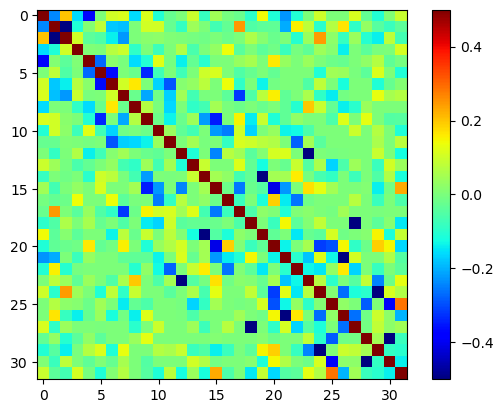

In [24]:
precMat,iter = ggmFitHtf(S, G, maxIter=100)
y = np.diag(precMat)
yy = np.outer(y,y)
yy = np.sqrt(yy)
parcor = precMat/yy 
plt.imshow(parcor,vmin = -0.5,vmax = 0.5,cmap = 'jet')
plt.colorbar()